In [1]:
### Training Neural Networks
# including helper functionalities
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable

## helper file

def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
### end of helper file

### Training Neural Networks
The network we built prior to this isnot that smart. It doesnt know anything about the handwritten digits. Neural networks with non linear activations works like universal function approximators. 
Our neural networks function maps input to the output. For example handwritten digits to class probabilities. 

The power of neural networks is that we can train them to approximate this functions, and basically any fucntion given enough data and compute time.

How does it work ?
At first the network has no idea about the data. It doesnot the function mapping the inputs to the outputs.  We would train the networks by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

How to find these paramters ?
To do that we need to know how badly the network is predicting the real outputs.  For this we calculate a  loss function, a measure of our predicting error.  Example - The mean squared loss is often used in regression and binary classification problems

loss = 1/2n(input - output)^2

input = true labels
output = predicted labels

By minimizing the loss wrt the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy.
We find this minimum using a process called gradient descent. The gradient is the slope of the loss functions and points in the direction of fastest change, To get to the minimum in the least amount of time we want to follow the gradient downward. 

### Backpropagation
For single layer networks, gradient descent is straightforward to implement. However for deeper networks its more complicated for deeper, multilayer neural networks like the one we have built. 

It all comes down to backpropagation which is really just an application of chain rule from calculus. 

To train the weights  with gradient descent, we pass the gradient of the loss backwards through the network. Each  operation has some gradient between inputs and outputs. As we send the gradient backwards, we multiply the incoming gradient with gradient for the operations. 

W1 = W1 - alpha * dL/dW1

Learning rate alpha is set such that weight update steps are small enought that the iterative method settles in a minimum

### Losses in PyTorch
Through the nn module, PyTorch provides losses such as the cross entropy loss (nn.CrossEntropyLoss). 

Here the loss will be assigned to criterion. 

With MNIST data, we are using the softmax function to predict class probabilities. With a softmax output, you want to use cross entropy as the loss. 

Here first define the criterio and then pass in the output of your network and the correct labels.

nn.CrossEntropyLoss, combines nn.LogSoftmax() and nn.NLLLoss() in one single class. 

Meaning -- Pass in the raw output of our network into the loss, not the output of the softmax function. This output is the logits or the scores.  Softmax gives you the probabilities which will often be very close to zero or one but floating-points numbers cant accurately represent values near zero or one. Its usually best to avoid doing calculations with probabilities, tpically we use log-probabilities



In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                               ])
# Download and load the training data
trainset = datasets.MNIST('~/PyTorchChallenge/MNIST_dara/', download = True, train=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [3]:
# Build a feed forward network
model = nn.Sequential(nn.Linear(784, 128),
                     nn.ReLU(),
                     nn.Linear(128, 64),
                     nn.ReLU(),
                     nn.Linear(64, 10)
                     )
# define the loss 
criterion = nn.CrossEntropyLoss()

# Get our Data
images, labels = next(iter(trainloader))

# Flatten the images
images = images.view(images.shape[0], -1)


# Forward pass, get our logits
logits = model(images)

# Calculate the loss with the logits and labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2913, grad_fn=<NllLossBackward>)


In [4]:
## Building a feed forward network
model = nn.Sequential(nn.Linear(784, 128),
                     nn.ReLU(),
                     nn.Linear(128, 64),
                     nn.ReLU(),
                     nn.Linear(64, 10),
                     nn.LogSoftmax(dim = 1)
                     )
# define the loss
criterion = nn.NLLLoss()

# Get our data
images, labels = next(iter(trainloader))

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)

# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3073, grad_fn=<NllLossBackward>)


### Autograd
Now we need to find the gradient at each step which done through backpropagation after getting the output from feedforward process.  

Torch provides a module, autograd for automatically calculating the gradients of all our parameters wrt the loss. 

Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. 

How to do that ?

Pytorch does exactly that by setting requires_grad = True on a tensor. you can do this at creation with the requires_grad keyword or at any time with x.requires_grad_(True)

In [5]:
# autograd
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007],
        [-0.0042, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042],
        [-0.0030, -0.0030, -0.0030,  ..., -0.0030, -0.0030, -0.0030],
        ...,
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [ 0.0021,  0.0021,  0.0021,  ...,  0.0021,  0.0021,  0.0021],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005]])


You can also turn off gradients for a block of code with torch.no_grad()

Globally -  torch.set_grad_enabled(True|False).

In [10]:
tr = torch.randn(2,2, requires_grad=True)
print(tr)
y = tr**2
print(y)
print(y.grad_fn)

tensor([[-0.8279,  0.7094],
        [ 0.1064, -0.1540]], requires_grad=True)
tensor([[0.6854, 0.5032],
        [0.0113, 0.0237]], grad_fn=<PowBackward0>)


The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, its able to caculate the gradients for a chain of operations, wrt any one tensor

In [13]:
z = y.mean()
print(z)
print(tr.grad)
z.backward()

tensor(0.3059, grad_fn=<MeanBackward1>)
None


### Training the network
How to train the network ?
To start training, an optimizer that we will use to update the weights with the gradient. Pytorch provides optim.SGD which is stochastic gradient descent

In [14]:
from torch import optim

#optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr = 0.01)

# lets try with one learning step before looping through all the data. 

### General process with PyTorch
1. Make a forward pass through the network
2. use the network output to calculate the loss
3. Perform a backward pass through the network with loss.backward() to calculate the gradients
4. Take a step with the optimizer to update the weights

In [15]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 0.0209,  0.0314, -0.0251,  ..., -0.0031, -0.0125,  0.0269],
        [-0.0178, -0.0182,  0.0284,  ..., -0.0022, -0.0103, -0.0105],
        [ 0.0103,  0.0128, -0.0061,  ..., -0.0226, -0.0184,  0.0086],
        ...,
        [-0.0100, -0.0303, -0.0227,  ..., -0.0175, -0.0089, -0.0342],
        [-0.0065, -0.0303, -0.0150,  ...,  0.0221,  0.0196, -0.0090],
        [-0.0255, -0.0233,  0.0005,  ..., -0.0003, -0.0086,  0.0345]],
       requires_grad=True)
Gradient - tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0031, -0.0031, -0.0031,  ..., -0.0031, -0.0031, -0.0031],
        [-0.0041, -0.0041, -0.0041,  ..., -0.0041, -0.0041, -0.0041],
        ...,
        [ 0.0086,  0.0086,  0.0086,  ...,  0.0086,  0.0086,  0.0086],
        [ 0.0009,  0.0009,  0.0009,  ...,  0.0009,  0.0009,  0.0009],
        [ 0.0010,  0.0010,  0.0010,  ...,  0.0010,  0.0010,  0.0010]])


In [16]:

# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)


Updated weights -  Parameter containing:
tensor([[ 0.0209,  0.0314, -0.0251,  ..., -0.0031, -0.0125,  0.0269],
        [-0.0178, -0.0181,  0.0285,  ..., -0.0021, -0.0103, -0.0105],
        [ 0.0103,  0.0128, -0.0061,  ..., -0.0226, -0.0183,  0.0087],
        ...,
        [-0.0101, -0.0304, -0.0228,  ..., -0.0176, -0.0090, -0.0343],
        [-0.0065, -0.0303, -0.0150,  ...,  0.0221,  0.0196, -0.0090],
        [-0.0255, -0.0233,  0.0005,  ..., -0.0003, -0.0086,  0.0345]],
       requires_grad=True)


In [ ]:
### Training for real

In [17]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                    )
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

epochs = 6
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step() # parameter update step based on the current gradient
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.0302011175895296
Training loss: 0.3794196746083719
Training loss: 0.32309446377413614
Training loss: 0.29099254774005173
Training loss: 0.2664174638164323
Training loss: 0.24529754484036584


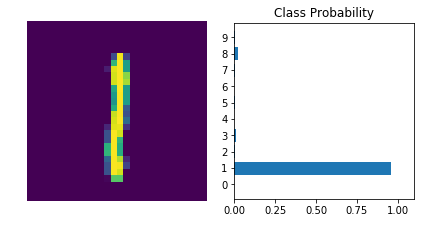

In [18]:
# with the network trained, we can check out its predictions
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)

# turn of gradients to speed up this part
with torch.no_grad():
    logps = model(img)
    
# output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
view_classify(img.view(1,28,28), ps)